# Chapter 3

This notebook contains the commands that are shown in the lectures.

In [1]:
library(tidyverse)
library(lubridate)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Problem 1

[read_table](https://readr.tidyverse.org/reference/read_table.html)

In [2]:
load_filesizes <- function(filesizes_file){
    filesizes <- read_table2(filesizes_file, col_names=c('Bytes','MonthsTo2021', 'Files'))
    
    filesizes <- filesizes %>%
    # Remove empty files
        filter(Bytes != 0) %>%
        # Create a column for log2 of bytes
        mutate(BytesLog2 = log2(Bytes)) %>%
        # Determine total space S used by N files of size X during date D: S=N*X 
        mutate(SpaceUsage = Bytes*Files) %>%
        # Determine file year and month from the MonthsTo2021-column
        mutate(
            TotalMonths = 2021*12 - MonthsTo2021 - 1,
            Year = TotalMonths %/% 12,
            Month = TotalMonths %% 12 +1,
            Day = 1
        )

     # Set year for really old files and files with incorrect timestamps
    invalid_years = c((filesizes['Year'] < 2010) | (filesizes['Year'] > 2020))
    filesizes[invalid_years, c('Year','Month')] <- NaN
    
    # Create Date and get the name for the month
    filesizes <- filesizes %>%
        mutate(
            Date = make_datetime(Year, Month, Day),
            MonthName= month(Month, label=TRUE, locale='C'))
    filesizes <- filesizes %>%
        # Sort data based on Date and BytesLog2
        arrange(Date, BytesLog2) %>%
        # Remove old columns
        select(-MonthsTo2021,-TotalMonths,-Day)
    return(filesizes)
}

filesizes <- load_filesizes('../data/filesizes_timestamps.txt')
head(filesizes)

Parsed with column specification:
cols(
  Bytes = col_double(),
  MonthsTo2021 = col_double(),
  Files = col_double()
)


Bytes,Files,BytesLog2,SpaceUsage,Year,Month,Date,MonthName
1,5,0,5,2010,1,2010-01-01,Jan
2,3,1,6,2010,1,2010-01-01,Jan
4,27,2,108,2010,1,2010-01-01,Jan
8,136,3,1088,2010,1,2010-01-01,Jan
16,208,4,3328,2010,1,2010-01-01,Jan
32,653,5,20896,2010,1,2010-01-01,Jan


In [22]:
newfiles_relevant <- filesizes %>%
    # Drop rows with NaNs (invalid years)
    drop_na() %>%
    # Pick relevant columns
    select(Year, Files) %>%
    # Change year to category for prettier plotting
    mutate(Year=as.factor(Year))
head(newfiles_relevant)

Year,Files
2010,5
2010,3
2010,27
2010,136
2010,208
2010,653


In [23]:
glimpse(newfiles_relevant)

newfiles_yearly_sum <- newfiles_relevant %>%
    group_by(Year) %>%
    summarize(Files=sum(Files))

glimpse(newfiles_yearly_sum)
head(newfiles_yearly_sum)

Observations: 4,698
Variables: 2
$ Year  <fct> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 201…
$ Files <dbl> 5, 3, 27, 136, 208, 653, 934, 824, 1679, 2151, 3056, 4642, 3649…
Observations: 11
Variables: 2
$ Year  <fct> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
$ Files <dbl> 5590287, 13197038, 17099900, 14755151, 26329321, 24896331, 4368…


Year,Files
2010,5590287
2011,13197038
2012,17099900
2013,14755151
2014,26329321
2015,24896331


In [21]:
newfiles_yearly_sum <- newfiles_yearly_sum %>%
    ungroup()

head(newfiles_yearly_sum)

Year,Files
2010,5590287
2011,13197038
2012,17099900
2013,14755151
2014,26329321
2015,24896331


Saving 6,67 x 6,67 in image


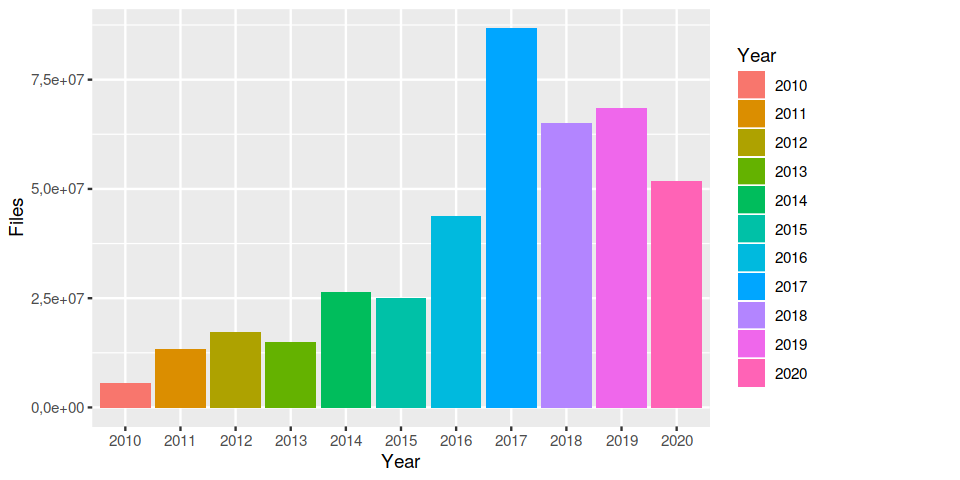

In [14]:
options(repr.plot.width=8, repr.plot.height=4)

newfiles_yearly_plot <-  newfiles_yearly_sum %>%
    mutate(Year=as.factor(Year)) %>%
    ggplot(aes(x=Year, y=Files, fill=Year)) +
    geom_col()

print(newfiles_yearly_plot)

ggsave('newfiles_yearly_sum_r.png')

In [8]:
options(repr.plot.width=12, repr.plot.height=2)

for (year in seq(min(years),max(years))) {
    yearly_data <- filesizes_yearly[filesizes_yearly['year'] == year,] %>%
        mutate(year=as.factor(year))
    print(yearly_data %>%
        ggplot(aes_(~ as.factor(bytes2), ~ n_total, fill=year)) +
            geom_bar(stat='identity', show.legend = FALSE) +
            ylab('N') +
            xlab('Bytes (log2)') +
            ggtitle(year))
}

ERROR: Error in min(years): invalid 'type' (closure) of argument


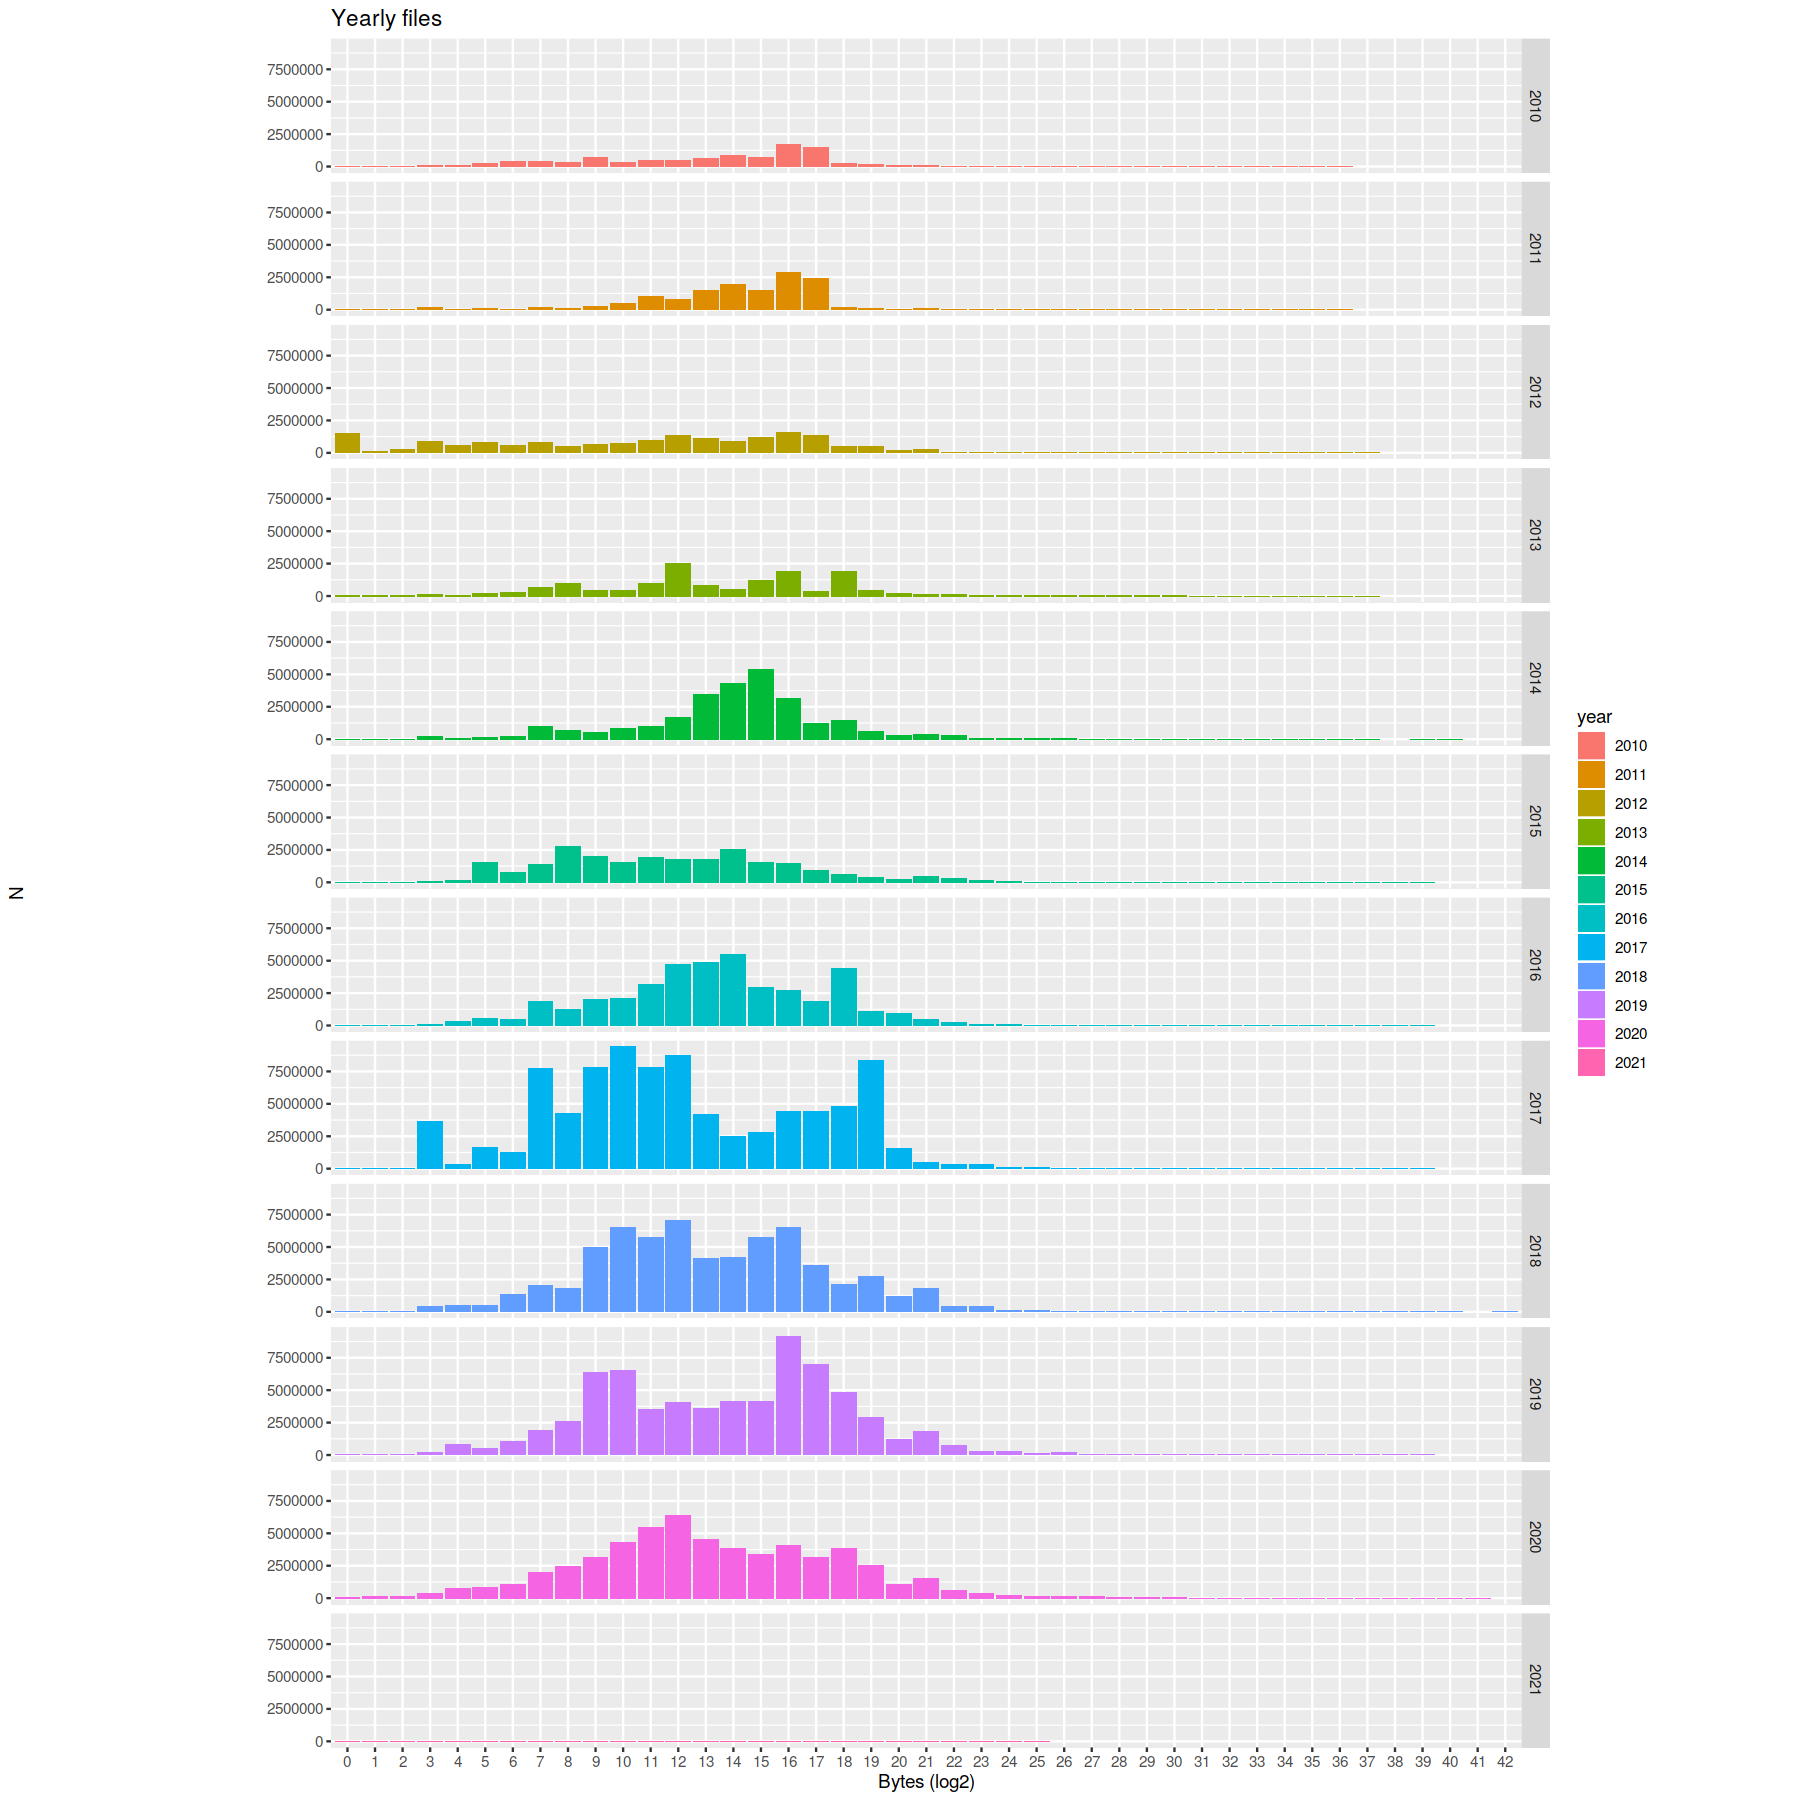

In [90]:
options(repr.plot.width=15, repr.plot.height=15)

filesizes_yearly %>%
    mutate(year=as.factor(year)) %>%
    ggplot(aes(x=as.factor(bytes2), y=n_total, fill=year)) +
        geom_bar(stat='identity') +
        ylab('N') +
        xlab('Bytes (log2)') +
        ggtitle('Yearly files') +
        facet_grid(rows=vars(year))

In [91]:
library(boot)

In [92]:
nsamples <- tibble(sample_number=seq(1000))

In [93]:
filesizes_sampled <- crossing(nsamples, years)

In [94]:
get_bootstrapped_mean <- function(year) {
    yearly_data <- filesizes_yearly %>%
        filter(year==year)
    bytes2 <- yearly_data$bytes2
    n_total <- yearly_data$n_total
    sampled_data <- sample(bytes2, 100, replace=TRUE, prob=n_total)
    return(mean(sampled_data))
}

In [250]:
get_bootstrapped_mean2 <- function(year, n_means=10000) {
    sampled_means <- numeric(n_means)
    years_data <- filesizes_yearly[filesizes_yearly['year'] == year,] %>%
        mutate(year=as.factor(year))
    bytes2 <- years_data$bytes2
    n_total <- years_data$n_total
    for (i in seq(n_means)) {
        sampled_means[[i]] <- sample(bytes2, 100, replace=TRUE, prob=n_total) %>%
            mean()
    }
    return(tibble(sampled_means=sampled_means))
}

In [251]:
get_bootstrapped_mean2(2012) %>%
    summarize(mean=mean(sampled_means))

mean
"10,67666"


In [252]:
get_bootstrapped_mean(2020)

[1] 13,28

In [96]:
time1 = Sys.time()
for (i in seq(10)) {
    filesizes_sampled %>%
        mutate(mean_fs=Vectorize(get_bootstrapped_mean)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

Time difference of 2,202973 secs


In [156]:
time1 = Sys.time()
for (i in seq(10)) {
    years %>%
        mutate(sampled_means=Vectorize(get_bootstrapped_mean2)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

Time difference of 0,9186298 secs


In [253]:
filesizes_sampled <- years %>%
    mutate(sampled_means=map(year, get_bootstrapped_mean2)) %>%
    unnest()

In [254]:
time1 = Sys.time()
for (i in seq(10)) {
    filesizes_sampled %>%
        mutate(mean_fs=Vectorize(get_bootstrapped_mean)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

In [175]:
filesizes_sampled['sampled_means'] <- as.numeric(map(filesizes_sampled$year, get_bootstrapped_mean))

In [255]:
filesizes_sampled %>%
    group_by(year) %>%
    summarize_all(.funs=c(mean))

year,sampled_means
2010,"13,18852"
2011,"14,12835"
2012,"10,66711"
2013,"13,42103"
2014,"14,02680"
2015,"11,72655"
2016,"13,40625"
2017,"12,12566"
2018,"13,13400"
2019,"13,72982"


Warning message:
“Removed 24 rows containing missing values (geom_bar).”

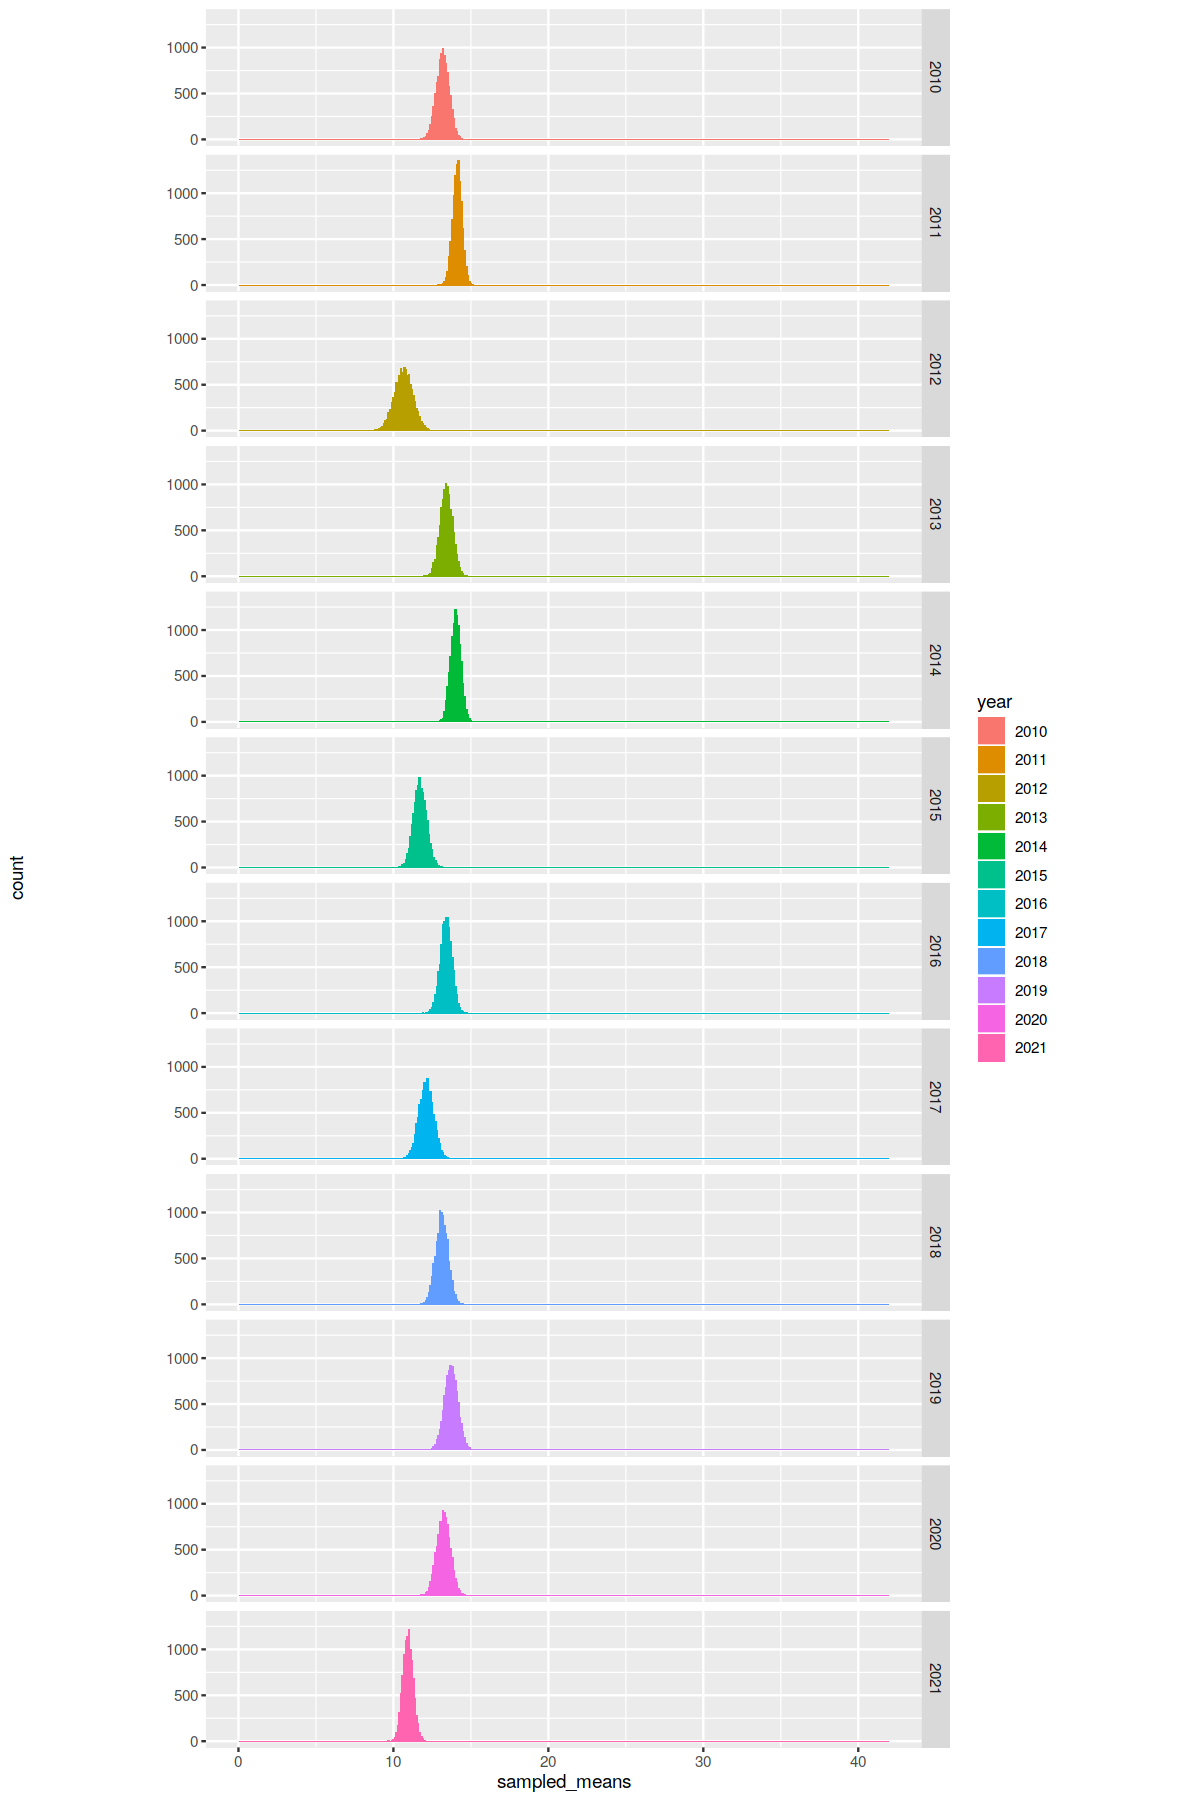

In [256]:
options(repr.plot.width=10, repr.plot.height=15)

filesizes_sampled %>%
    select(year, sampled_means) %>%
    mutate(year=as.factor(year)) %>%
    ggplot(aes(x=sampled_means, fill=year)) +
        geom_histogram(binwidth=0.1) +
        xlim(range(bytes2)) +
#        ylab('N') +
#        xlab('Bytes (log2)') +
#        ggtitle('Yearly files') +
        facet_grid(rows=vars(year))